# Esame di Metodi Numerici - 6 Luglio 2023

##                             Turno I  ore 9-11.30


## Esercizio 1


Nel file ``Test_I.mat`` sono memorizzate le matrici A1, A2 ed A3 ed i vettori b1,b2,b3. Risolvere i 3 sistemi lineari aventi ciascuno di essi come matrice dei coefficienti A1 e termine noto b1, A2 e termine noto b2, A3 e terimine noto b3  utilizzando il metodo più adatto per ciascuno di essi e  commentare i risultati ottenuti  giustificandoli alla luce della teoria.
Verificare se le matrici sono malcondizionate, dire teoricamente cosa questo implica e verificarlo sperimentalmente almeno per una di esse.


Per la lettura dei dati procedere nel seguente modo:

``from scipy.io import loadmat``

``import numpy as np``

``dati = loadmat('Test_I.mat')``

``A1=dati["A1"] ``

``A1=A1.astype(float)``

`` b1=dati["b1"] ``

`` b1=b1.astype(float)``

``A2=dati["A2"] ``

``A2=A2.astype(float)``

`` b2=dati["b2"] ``

`` b2=b2.astype(float)``

``A3=dati["A3"] ``

``A3=A3.astype(float)``

`` b3=dati["b3"] ``

`` b3=b3.astype(float)``



                                                                    Punti 16

In [5]:
from scipy.io import loadmat

import numpy as np

dati = loadmat('Test_I.mat')

A1=dati["A1"] 

A1=A1.astype(float)

b1=dati["b1"] 

b1=b1.astype(float)

A2=dati["A2"] 

A2=A2.astype(float)

b2=dati["b2"] 

b2=b2.astype(float)

A3=dati["A3"] 

A3=A3.astype(float)

b3=dati["b3"] 

b3=b3.astype(float)

In [6]:

def getInfo(A):
    print(A.shape)
    print("condizionamento => {:e}".format(np.linalg.cond(A)))
    perc = np.count_nonzero(A)
    perc = perc/(A.shape[0] * A.shape[1]) * 100
    if perc <= 33:
        print("sparsa")
    else:
        print("densa")
    maxRank(A)
    diagStrettDominante(A)
    if A.shape[0] == A.shape[1]:
        simmetrica(A)

def simmetrica(A):
    if np.all(A.T==A):
        print("simmetrica")
        defPos(A)

def defPos(A):
    val,vect = np.linalg.eig(A)
    flag = val>0
    if np.all(flag):
        print("definita positiva")

def maxRank(A):
    if np.linalg.matrix_rank(A) == min(A.shape):
        print("rango massimo")

def diagStrettDominante(A):
    if np.all(np.diag(A)>np.abs(A-np.diag(A))):
        print("diagonale strettamente dominante")


getInfo(A1)
print("------------------")
getInfo(A2)
print("------------------")
getInfo(A3)
print("------------------")

(10, 10)
condizionamento => 1.206149e+02
densa
rango massimo
simmetrica
------------------
(25, 10)
condizionamento => 1.000000e+04
densa
rango massimo
------------------
(225, 225)
condizionamento => 1.030869e+02
sparsa
rango massimo
simmetrica
definita positiva
------------------


A1 => matrice di piccole dimensioni,quadrata, densa e ben condizionata quindi utilizzo la fattorizzazzione di Gauss.

A2 => sistema sovradeterminato, mal condizionata, e a rango massimo allora utilizzo il metodo SVDLS oppure qrLS dato che non è molto mal condizionata ed ha il rango massimo.

A3 => matrice di grandi dimensioni, sparsa, simmetrica e definita positiva quindi potrei utilizzare Gauss-Seidel,Gauss-SeidelSor,SteepestGradient oppure Conjugate-Gradient.

In [14]:
import scipy.linalg as splin
import RisolviSis as solver
import matplotlib.pyplot as plt
def Gauss(A,b):
    P,L,U = splin.lu(A)
    Pb = P.T@b
    y,flag = solver.Lsolve(L,Pb)
    x,flag = solver.Usolve(U,y)
    return x

def SVDLS(A,b):
    #Risolve un sistema sovradeterminato con il metodo SVD-LS
    m,n=A.shape  #numero di righe e  numero di colonne di A
    U,s,VT=splin.svd(A)  #Attenzione : Restituisce U, il numpy-array 1d che contiene la diagonale della matrice Sigma e VT=VTrasposta)
    #Quindi 
    V=VT.T
    thresh=np.spacing(1)*m*s[0] ##Calcolo del rango della matrice, numero dei valori singolari maggiori di una soglia
    k=np.count_nonzero(s>thresh)
    print("rango=",k)
    d=U.T@b
    d1=d[:k].reshape(k,1)
    s1=s[:k].reshape(k,1)
    #Risolve il sistema diagonale di dimensione kxk avene come matrice dei coefficienti la matrice Sigma
    c=d1/s1
    x=V[:,:k]@c 
    residuo=np.linalg.norm(d[k:])**2
    return x,residuo
def qrLS(A,b):
#Risolve un sistema sovradeterminato con il metodo QR-LS
    n=A.shape[1]  # numero di colonne di A
    Q,R=splin.qr(A)
    h=Q.T@b
    x,flag=solver.Usolve(R[0:n,:],h[0:n])
    residuo=np.linalg.norm(h[n:])**2
    return x,residuo

def gauss_seidel(A,b,x0,toll,it_max):
    errore=1000
    d=np.diag(A)
    D=np.diag(d)
    E=np.tril(A,-1)
    F=np.triu(A,1)
    M=(E+D)
    N=-F
    T=np.dot(np.linalg.inv(M),N)
    autovalori=np.linalg.eigvals(T)
    raggiospettrale=np.max(np.abs(autovalori))
    print("raggio spettrale Gauss-Seidel ",raggiospettrale)
    it=0
    er_vet=[]
    while it<=it_max and errore >= toll:
        temp=b-F@x0
        x,flag= solver.Lsolve(M,temp)
        errore=np.linalg.norm(x-x0)/np.linalg.norm(x)
        er_vet.append(errore)
        x0=x.copy()
        it=it+1
    return x,it,er_vet

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
-----------------
rango= 10
soluzione x2 =>  [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]] 
 residuo =>  3.016794600110773e-28
soluzione con QRLS x2 =>  [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]] 
 residuo  con QRLS =>  3.016794600110773e-28
-----------------
raggio spettrale Gauss-Seidel  0.9619397662556403


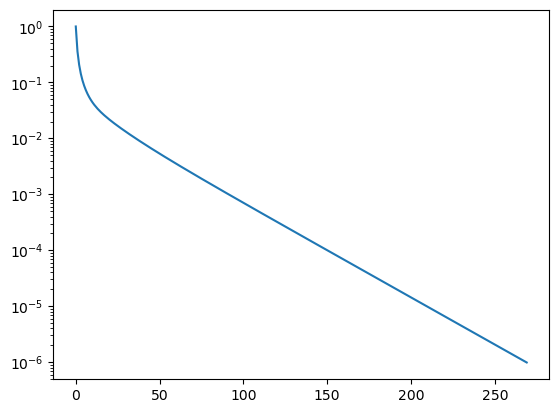

In [15]:
x1 = Gauss(A1,b1)
print(x1)
print("-----------------")
x2,res2 = SVDLS(A2,b2)
print("soluzione x2 => ",x2,"\n residuo => ",res2)
x2bis,res2bis = qrLS(A2,b2)
print("soluzione con QRLS x2 => ",x2,"\n residuo  con QRLS => ",res2)
print("-----------------")

toll = 1e-6
itMax = 400
x0 = np.zeros((A3.shape[0],1))

x3,it3,errore3 = gauss_seidel(A3,b3,x0,toll,itMax)

plt.semilogy(range(it3),errore3)
plt.show()

Il condizionamento di una matrice ci dice di quanto la permutazione sui dati influisce il risultato finale, nel nostro caso abbiamo che la matrice A2 è mal condizionata, quindi se noi la andiamo a permutare potremmo avere un risultato che non converge con l'effettivo risultato mentre per le altre due matrici il risultato convergerà sicuramente di più rispetto ad A2:

[[0.99883188]
 [0.99643868]
 [0.99879018]
 [1.00358782]
 [0.99779629]
 [0.99958003]
 [1.00074722]
 [1.0011436 ]
 [1.00203987]
 [1.00051127]]
errore relativo sul risultato => 1.992610e-03
rango= 10
SVDLS =>  [[0.93806516]
 [0.96654088]
 [0.94325957]
 [1.0718793 ]
 [1.00610063]
 [0.99677973]
 [1.01182611]
 [1.09443207]
 [0.94325452]
 [0.96174441]]
errore relativo sul risultato => 5.208641e-02
QRLS =>  [[0.93806516]
 [0.96654088]
 [0.94325957]
 [1.0718793 ]
 [1.00610063]
 [0.99677973]
 [1.01182611]
 [1.09443207]
 [0.94325452]
 [0.96174441]]
errore relativo sul risultato => 5.208641e-02
raggio spettrale Gauss-Seidel  0.961939722763806


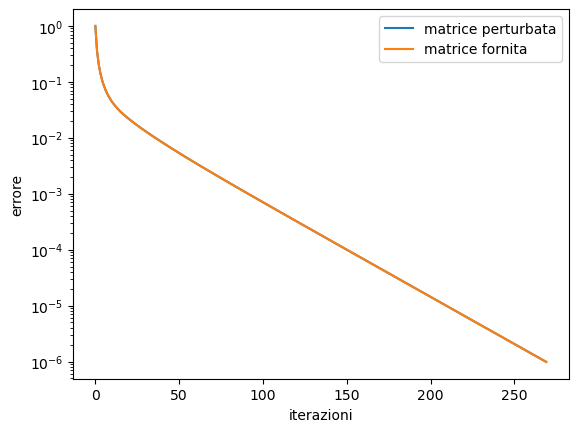

errore relativo sul risultato => 9.799014e-05


In [33]:
def calcErrRel(expected,obtained):
    return np.linalg.norm(obtained-expected,2)/np.linalg.norm(expected,2)

A1per = A1.copy()
A1per[0][0] = A1per[0][0]+0.001*A1per[0][0]
x1per = Gauss(A1per,b1)
print(x1per)
print("errore relativo sul risultato => {:e}".format(calcErrRel(x1,x1per)))

A2per = A2.copy()
A2per[0][0] = A2per[0][0] + A2per[0][0]*0.001
x2per,res2per = qrLS(A2per,b2)
x2perbis,res2perBis = SVDLS(A2per,b2)
print("SVDLS => ",x2perbis)
print("errore relativo sul risultato => {:e}".format(calcErrRel(x2,x2perbis)))
print("QRLS => ",x2per)
print("errore relativo sul risultato => {:e}".format(calcErrRel(x2,x2per)))

A3per = A3.copy()
A3per[0][0] = A3per[0][0] + A3per[0][0]*0.001
x3per,it3per,err3per = gauss_seidel(A3per,b3,x0,toll,itMax)

plt.semilogy(range(it3per),err3per)
plt.semilogy(range(it3),errore3)
plt.legend(["matrice perturbata","matrice fornita"])
plt.ylabel("errore")
plt.xlabel("iterazioni")
plt.show()
print("errore relativo sul risultato => {:e}".format(calcErrRel(x3,x3per)))



# Esercizio 2

Data l'equazione di 2° grado $$\frac{1}{2} x^2+2bx-c=0$$

con $b=10^8, c=2^{-i},i=-5,\cdots, 9$

- a) Scrivere le due formule algebriche per ricavare i valori delle 2 soluzioni

                                                                                    1 punto
- b) Studiare l'indice di condizionamento delle 2 formule algebriche, facendo uso del risultato teorico visto a lezione riguardo l'indice di condizionamento della valutazione di una funzione. (Spiegare il significato di problema mal condizionato) e dire quale delle due formule è malcondizionata. Per quali valori di $c$ il problema risulterebbe ben condizionato?

                                                                                    5 punti

- c) Nel caso in cui una delle due formule risulti mal condizionata, proporre una soluzione algebricamente equivalente che non sia malcondizionata.

                                                                                    3 punti

x1 => 
 [1.49011612e-07 8.94069672e-08 2.98023224e-08 2.98023224e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
x2 => 
 [-4.e+08 -4.e+08 -4.e+08 -4.e+08 -4.e+08 -4.e+08 -4.e+08 -4.e+08 -4.e+08
 -4.e+08 -4.e+08 -4.e+08 -4.e+08 -4.e+08 -4.e+08]
---------------------------------
spacing di 2b^2 => 
 8.0
valori di 2*c => 
 [3.200000e+01 1.600000e+01 8.000000e+00 4.000000e+00 2.000000e+00
 1.000000e+00 5.000000e-01 2.500000e-01 1.250000e-01 6.250000e-02
 3.125000e-02 1.562500e-02 7.812500e-03 3.906250e-03 1.953125e-03]
---------------------------------
condizionamento 1=>
 [953.67431641 286.10229492  47.68371582  23.84185791   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.        ]
condizionamento 2=>
 [2.5600e+18 1.2800e+18 6.4000e+17 3.2000e+17 1.6000e+17 8.0000e+16
 4.0000e+16 2.0000e+16 1.000

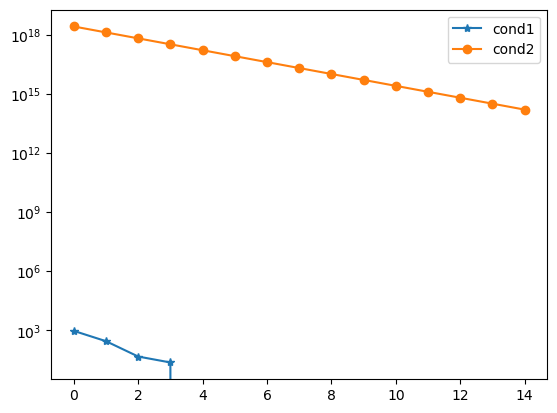

In [252]:
import sympy as sym
import sympy.utilities.lambdify as lamb

x = sym.symbols("x")
b = sym.symbols("b")
c = sym.symbols("c")

# x12 = (-b+-delta)/2a => -b+-delta => delta = np.sqrt(b**2-2c)

x1 = -b+sym.sqrt(b**2+2*c)
x2 = -b-sym.sqrt(b**2+2*c)
x1d = sym.diff(x1,c)
x2d = sym.diff(x2,c)

x1_b = x1.subs(b,2*10**8)
x2_b = x2.subs(b,2*10**8)
x1d_b = x1d.subs(b,2*10**8)
x2d_b = x2d.subs(b,2*10**8)

i = np.arange(-5,10)
vec_i = 2.0**(-i)

fx1 = lamb(c,x1_b,np)
fx2 = lamb(c,x2_b,np)
fdx1 = lamb(c,x1d_b,np)
fdx2 = lamb(c,x2d_b,np)


sol1 = fx1(vec_i)
sol2 = fx2(vec_i)
print("x1 => \n",sol1)
print("x2 => \n",sol2)
print("---------------------------------")
print("spacing di 2b^2 => \n",np.spacing(4*10**16))
print("valori di 2*c => \n",vec_i)
print("---------------------------------")
cond1 = np.abs(fx1(vec_i)*vec_i / fdx1(vec_i))
print("condizionamento 1=>\n",cond1)
cond2 = np.abs(fx2(vec_i)*vec_i / fdx2(vec_i))
print("condizionamento 2=>\n",cond2 )
plt.semilogy(cond1,"-*",cond2,"-o")
plt.legend(["cond1","cond2"])
plt.show()

In [ ]:
tramite cond2 possiamo vedere come la seconda formula risolutiva sia malcondizionata dato che assume valori enormi

                                                                        Totale 9 punti

## Domanda intelligenza artificiale

- Limiti delle reti MLP (multilayer Perceptron) ed introduzione delle Reti neurali Convoluzionali. 
- Architettura di una rete neurale convoluzionale: strati convoluzionali, attivazione non lineare e pooling + parte fully connected.
- Loss function per il task della regressione.  Training di una rete. 
- Cenni sull'algoritmo di backpropagation per il calcolo delle derivate parziale della funzione costo rispetto ai pesi ditutti i layer .
- Tecniche di Ottimizzazione: metodo di discesa del gradient batch, metodo del gradiente stocastico (SGD) ,metodo del gradiente stocastico minibatch.
                                                                                [7  punti]
